[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

## Que es SSD?

Single Shot Multibox detector, es un algoritmo de deteccion de objetos en tiempo real, que puede detactar multiples objetos en tiempo real, que puede detectar multiples objetos en una imagen en una sola pasada de la red neuronal.

### . Detección en una sola pasada (Single Shot)
* **YOLO y SSD:** Realizan detección y clasificación en una sola pasada

* **vs. R-CNN:** Los métodos de dos pasas (como R-CNN) primero proponen regiones y luego las clasifican

## Implemantacion de SSD

In [119]:
# Verificamos si tenemos GPU

import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Vamos a utilizar el mismo dataset que conocemos de posts anteriores, el dataset `VOC`.

In [120]:
# Cargamos el dataset (asegúrate de tener los datos descargados previamente)

train = torchvision.datasets.VOCDetection(
    './data', 
    year='2012', 
    image_set='trainval',
    download=False  
)
len(train)

11540

In [121]:
classes = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]
print(f"Se tiene un total de {len(classes)} clases: {classes}")

Se tiene un total de 21 clases: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


Las siguientes funciones nos ayudan a extraer la información que necesitamos de las anotaciones y a visualizar muestras del dataset.

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object'] # puede ser una lista o un diccionario
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax']),int(bb['ymax'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs): #iteramos sobre las etiquetas y bounded boxes
    if bg == -1 or lab != bg:  #verifica si es un background, si no es entonces lo grafica, sive para evitar backhgrounds
      x, y, xm, ym = bb #extraemos esquina superior, esquinas inferiores del bounded box
      w, h = xm - x, ym - y
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2) #crea un rectangulo rojo sin relleno para visualizar el bb
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'}) #coloca el texto con el nombre de la clase arriba del bounded box
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')]) # añade contorno blanco para mejorar visibilidad
      ax.add_patch(rect) # añade el rectangulo grafico

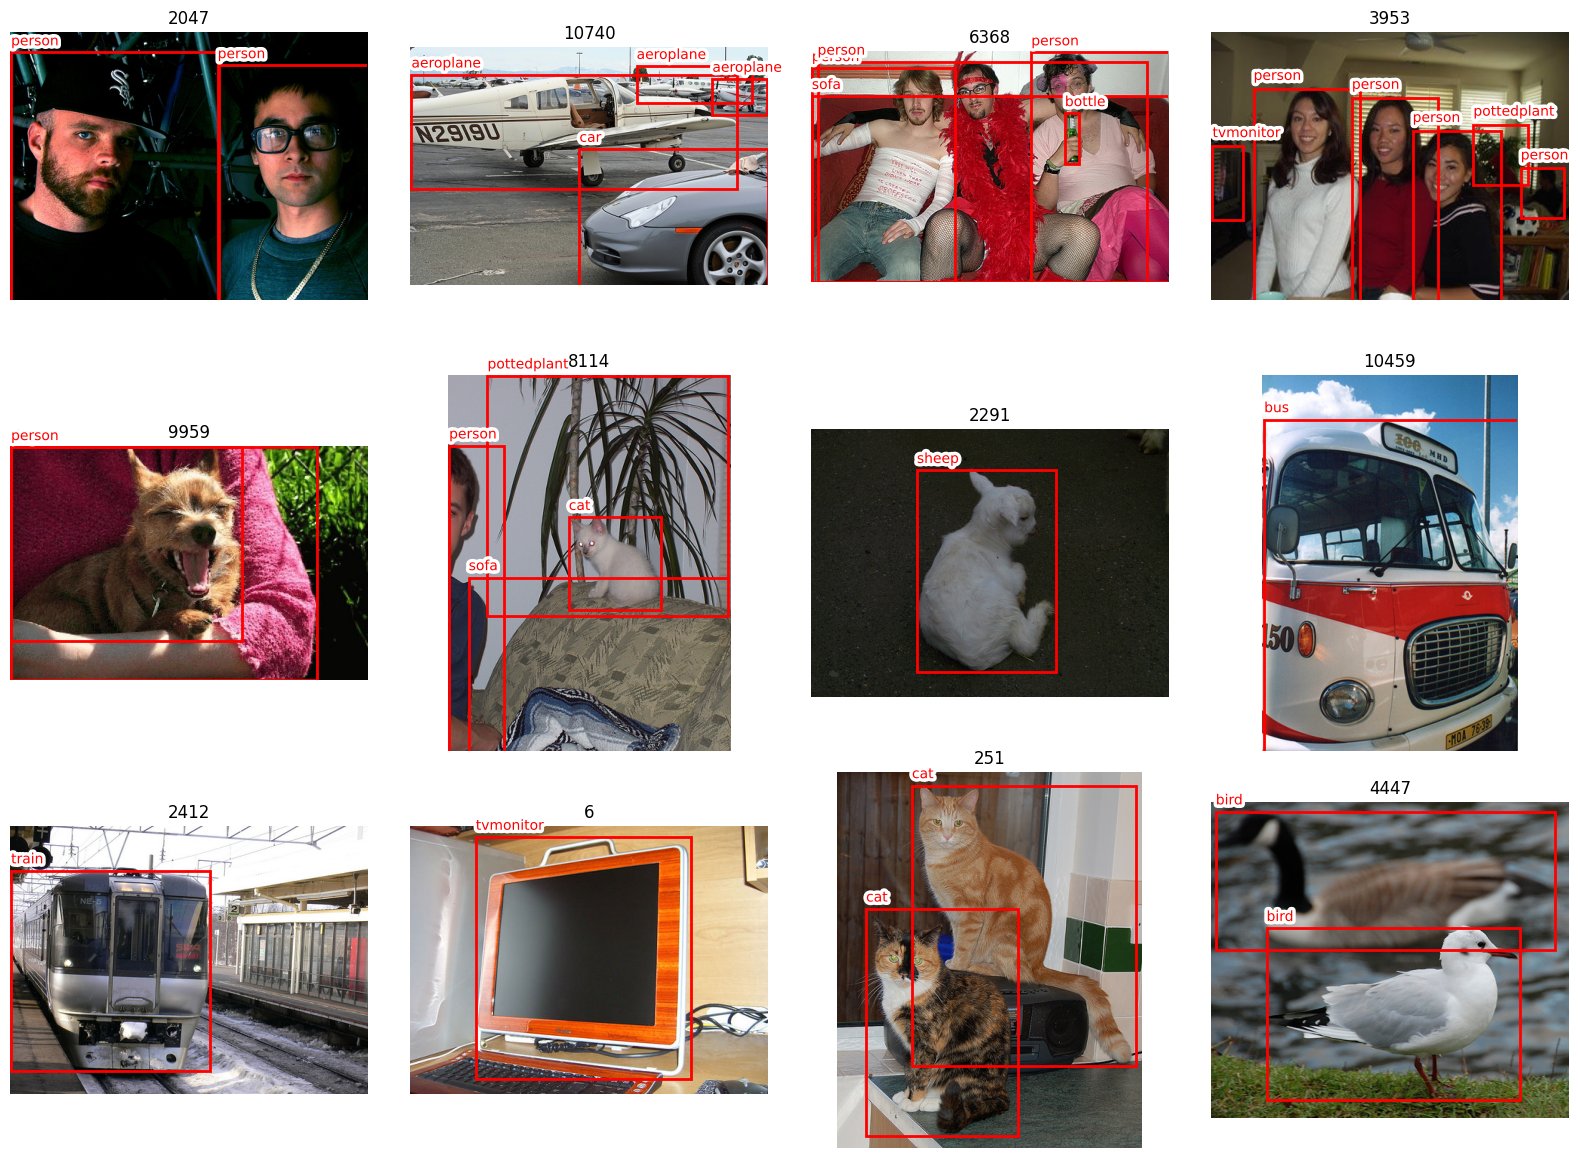

In [123]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [124]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  
  h, w = shape #obtener height y width
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h]) # normalizar bb dividendo entre width y height

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  
  h, w = shape #obtener height y width
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h]) # desnormalizar bb multiplicando entre width y height

def xyxy2xywh(bb):
  # formato de entrada bb = [x_min, y_min, x_max, y_max]
  # para x_min bb[:,0], 
  # para y_min bb[:,1], 
  # para width bb[:,2] - bb[:,0], 
  # para height bb[:,3] - bb[:,1]
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1) # retorna tensor con formato [x_min, y_min, width, height]

def xywh2xyxy(bb):
  # formato de entrada bb = [x_min, y_min, width, height]
  # para x_min bb[:,0],
  # para y_min bb[:,1],
  # para x_max bb[:,0] + bb[:,2],
  # para y_max bb[:,1] + bb[:,3]
  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1) # retorna tensor con formato [x_min, y_min, x_max, y_max]

# Esta funcion genera los anchors
# scales: lista con los tamaños de las feature maps
# centers: lista con las coordenadas de los centros de los anchors
# sizes: lista con los tamaños (width, height) de los anchors
def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], [] # Inicializamos las listas
    for s in scales: #iteramos sobre las escalas
        cnt = 0 #contador de anchors por escala
        for (x, y) in centers: #iteramos sobre los centros
            for (w, h) in sizes: #iteramos sobre los tamaños
                for i in range(s): #iteramos sobre la escala
                    for j in range(s): #iteramos sobre la escala
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s) #guardamos los anchors en formato xyxy con forma [ x_min, y_min, x_max, y_max], normalizados
                        grid_size.append(np.array([1./s,1./s])) #guardamos el tamaño de la feature map normalizado
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float() # retornamos k, anchors y grid_size como tensores de tipo float

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

El aspect ratio (relación de aspecto) es la proporción entre el ancho y el alto de un objeto, en este caso, de los bounding boxes o anchor boxes.

**¿Qué es el aspect ratio?**

+ Aspect Ratio = ancho / alto

In [125]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  # anns is a tuple with (bbs, labels)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max]
  # labels is an array containing the label
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns #extraemos las etiquetas y bounded boxes

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors]) # desnormalizamos los anchors
  for a in _anchors: #iteramos sobre los anchors
    x, y, w, h = a #extraemos x_min, y_min, width, height
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='yellow', linewidth=2) #crea un rectangulo amarillo sin relleno para visualizar el anchor box
    ax.add_patch(rect) # añade el rectangulo grafico

  labels, bbs = anns #extraemos las etiquetas y bounded boxes
  for lab, bb in zip(labels, bbs): #iteramos sobre las etiquetas y bounded boxes
    x, y, xm, ym = bb #extraemos esquina superior, esquinas inferiores del bounded box
    w, h = xm - x, ym - y #calculamos width y height
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2) #crea un rectangulo rojo sin relleno para visualizar el bb
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'}) #coloca el texto con el nombre de la clase arriba del bounded box
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')]) # añade contorno blanco para mejorar visibilidad
    ax.add_patch(rect)  # añade el rectangulo grafico

Para este ejemplo se tomara una imagen al azar

(276, [6, 6, 6])

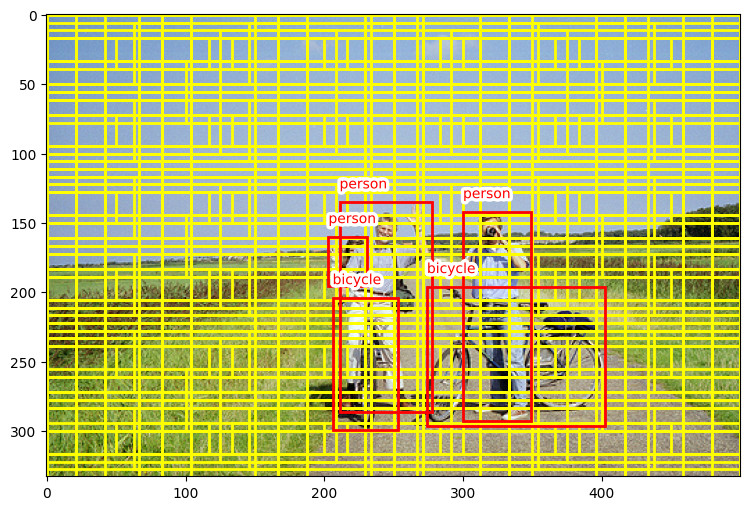

In [153]:
ix = 2000 # tomamos la imagen 10285
img_np, anns = get_sample(ix) # obtenemos la imagen y las anotaciones
labels, bbs = anns #extraemos las etiquetas y bounded boxes

scales = [6, 3, 1] # diferentes tamaños de feature maps
# scales = [1]
# scales = [1]

centers = [(0.5, 0.5)] # centro de los anchors, define desde donde se empiezan a generar los anchors
# centers = [(0, 0)]
#size_scales = [0.5]
size_scales = [1, 3] # escala de los anchors

aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)] # diferentes aspect ratios
# aspect_ratios = [(1., 1.)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios] # combinamos escala y aspect ratio para obtener los tamaños (width, height)
k, anchors, grid_size = generate_anchors(scales, centers, sizes) # generamos los anchors

plot_anchors(img_np, anns, anchors)
len(anchors), k

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [127]:
import torch.nn as nn

# Definimos el modelo SSD
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2): # bloque de convolución, con kernel size k, padding p, stride s, pooling kernel size pk y pooling stride ps
    # retorna una secuencia de capas: Conv2d -> ReLU -> MaxPool2d
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )
# Esta funcion aplana la salida de la convolución para que pueda ser procesada por las capas fully connected
def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

# Capa de salida que predice las localizaciones y clases
class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k # número de anchors por celda
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1) # predice las localizaciones
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1) # predice las clases
    def forward(self, x):
        # retorna las localizaciones y clases predichas
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

# Función para crear una capa de convolución seguida de ReLU (y opcionalmente BatchNorm)
def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding),
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

class SSD(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
        super().__init__()
        # backbone
        self.conv1 = block(n_channels, 8)
        self.conv2 = block(8, 16)
        self.conv3 = block(16, 32)
        self.conv4 = block(32, 64)
        self.conv5 = block(64, 64)
        self.conv6 = block(64, 64)
        # head
        self.k = k
        self.out4 = out_conv(64, self.k[0], n_classes)
        self.out5 = out_conv(64, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

    def forward(self, x):
        # backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)     # para inputs de 100x100
        x4 = self.conv4(x)    # 6x6
        x5 = self.conv5(x4)   # 3x3
        x6 = self.conv6(x5)   # 1x1

        # head
        o1l, o1c = self.out4(x4)
        o2l, o2c = self.out5(x5)
        o3l, o3c = self.out6(x6)
        return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)
        #return o2l, o2c

In [128]:
# instanciamos el modelo y probamos una pasada con datos aleatorios
net = SSD(n_classes=len(classes), k=k)
output = net(torch.rand((64,3,100,100)))
output[0].shape, output[1].shape # nos da la forma de las localizaciones y clases predichas, 
# (torch.Size([64, 138, 4]), torch.Size([64, 138, 21])) es de forma (batch_size, num_anchors, 4) y (batch_size, num_anchors, num_classes)

(torch.Size([64, 138, 4]), torch.Size([64, 138, 21]))

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 21 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% del tamaños de la caja en ambas dimensiones.

In [129]:
# Función para convertir las predicciones de localización a bounding boxes
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn) # limitamos las predicciones entre -1 y 1
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5 # calculamos la esquina superior izquierda
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5 # calculamos la esquina inferior derecha
    return torch.cat([actn_p1, actn_p2], dim=1) # retornamos las bounding boxes en formato [x_min, y_min, x_max, y_max]

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante. También puede ocurrir que no haya ninguna caja que cumpla estos requisitos, es este caso le asignaremos aquella con mayor `IoU`.

In [130]:
# función para mapear las predicciones a las ground truth
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1) # obtenemos el máximo overlap para cada anchor
    gt_overlap, gt_idx = overlaps.max(0) # obtenemos el máximo overlap para cada ground truth
    gt_overlap[prior_idx] = 1.99 # aseguramos que cada anchor tenga un ground truth asignado
    for i,o in enumerate(prior_idx): gt_idx[o] = i # asignamos el índice del ground truth al anchor correspondiente
    return gt_overlap, gt_idx # retornamos el overlap y los índices de los ground truth asignados

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [131]:
# Definimos la clase de pérdida para el SSD
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss() # pérdida para las localizaciones
        self.class_loss = torch.nn.CrossEntropyLoss() # pérdida para las clases 
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold # umbral de IoU para considerar una predicción como positiva

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds
        tar_bbs, c_t = target # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                # filtramos por aquellas que superen el umbral
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0] # obtenemos los índices de las predicciones que superaron el filtro
                tar_idx = gt_idx[pos_idx] # obtenemos los índices de las ground truth asignadas a esas predicciones
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size) # convertimos las predicciones a bounding boxes
                _anchors = pred_bb[pos_idx] # nos quedamos con las predicciones que superaron el filtro
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

<>:18: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
<>:18: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
C:\Users\Animetx\AppData\Local\Temp\ipykernel_22112\378608841.py:18: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones


## Entrenamiento

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [132]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles. Utilizamos albumentations para hacer el *resize* de la imagen y anotaciones.

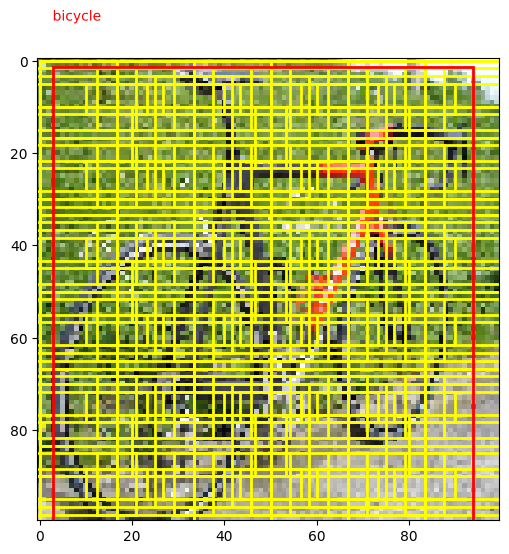

In [133]:
import albumentations as A

# Probamos las transformaciones con albumentations
trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns #extraemos las etiquetas y bounded boxes
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels}) # aplicamos las transformaciones
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels'] # obtenemos la imagen transformada, las bounding boxes y las etiquetas

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [134]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device) # normalizamos la imagen y la convertimos a tensor
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs] # normalizamos las bounding boxes
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device) # convertimos las bounding boxes a tensor
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device) # convertimos las etiquetas a tensor

img_tensor.shape, bb_tensor.shape, label_tensor.shape 
# (torch.Size([1, 3, 100, 100]), torch.Size([1, 1, 4]), torch.Size([1, 1]))
# (batch_size, channels, height, width), (batch_size, num_boxes, 4), (batch_size, num_boxes)

(torch.Size([1, 3, 100, 100]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [135]:
model = SSD(n_classes = len(classes), k=k)
fit(model, img_tensor, (bb_tensor, label_tensor), epochs=100)

Epoch 1/100 loss 3.14995
Epoch 2/100 loss 3.14102
Epoch 3/100 loss 3.13224
Epoch 4/100 loss 3.12338
Epoch 5/100 loss 3.11418
Epoch 6/100 loss 3.10441
Epoch 7/100 loss 3.09379
Epoch 8/100 loss 3.08203
Epoch 9/100 loss 3.06882
Epoch 10/100 loss 3.05389
Epoch 11/100 loss 3.03683
Epoch 12/100 loss 3.01714
Epoch 13/100 loss 2.99444
Epoch 14/100 loss 2.96880
Epoch 15/100 loss 2.93918
Epoch 16/100 loss 2.90481
Epoch 17/100 loss 2.86482
Epoch 18/100 loss 2.82019
Epoch 19/100 loss 2.76928
Epoch 20/100 loss 2.71068
Epoch 21/100 loss 2.64246
Epoch 22/100 loss 2.56316
Epoch 23/100 loss 2.47388
Epoch 24/100 loss 2.37509
Epoch 25/100 loss 2.26533
Epoch 26/100 loss 2.13923
Epoch 27/100 loss 1.99608
Epoch 28/100 loss 1.83626
Epoch 29/100 loss 1.66192
Epoch 30/100 loss 1.47974
Epoch 31/100 loss 1.29640
Epoch 32/100 loss 1.11872
Epoch 33/100 loss 0.94856
Epoch 34/100 loss 0.79246
Epoch 35/100 loss 0.65403
Epoch 36/100 loss 0.53020
Epoch 37/100 loss 0.42204
Epoch 38/100 loss 0.32837
Epoch 39/100 loss 0.2

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [136]:
# Función para hacer predicciones con el modelo entrenado
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [137]:
# probamos la función de predicción
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

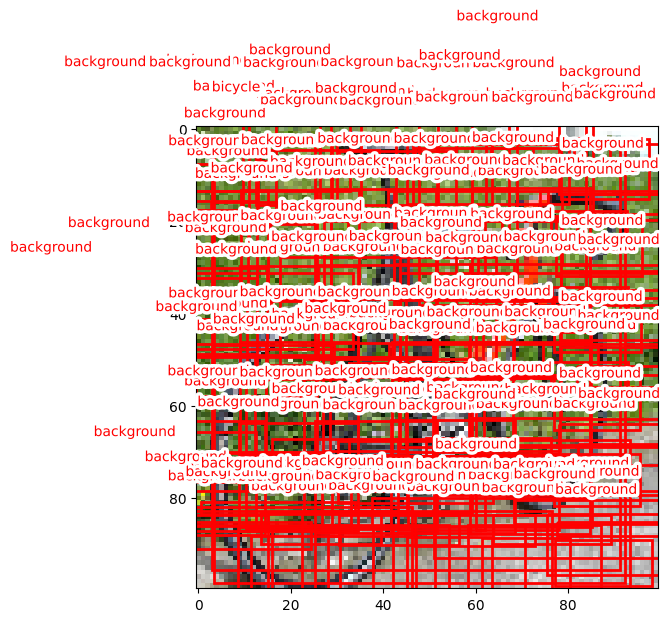

In [138]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

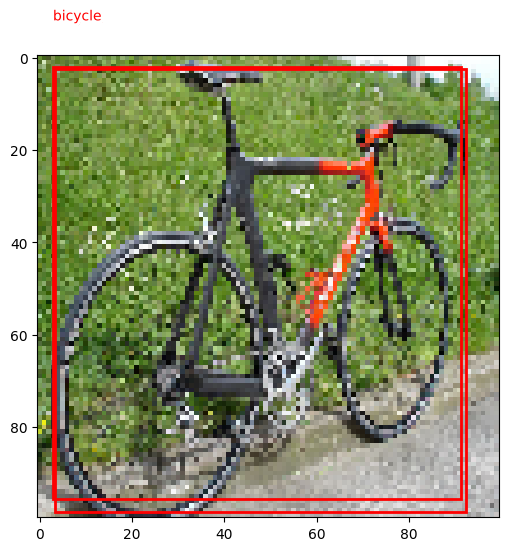

In [139]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [140]:
bbs, (scores, labels) = predict(model, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.0338, 0.0239, 0.9229, 0.9834],
         [0.0288, 0.0194, 0.9119, 0.9550]]),
 tensor([2, 2]),
 tensor([0.9377, 0.9015]))

**Antes del NMS:**

```py
Detección A: score=0.9, bbox=[100,50,200,150]  ← Seleccionada
Detección B: score=0.7, bbox=[105,55,205,155]  ← IoU > 0.8 → Eliminada
Detección C: score=0.6, bbox=[110,60,210,160]  ← IoU > 0.8 → Eliminada
```


**Después del NMS:**
Solo Detección A permanece

In [141]:
# Aplicamos Non-Maximum Suppression (NMS) para filtrar las predicciones
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

tensor([0])

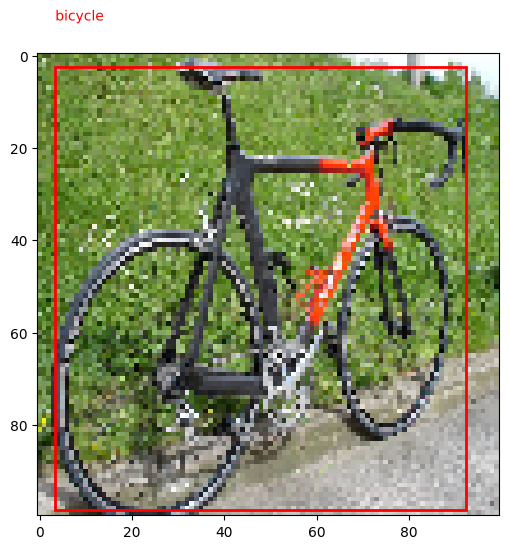

In [142]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.